# 1 Introduction

Instacart is an on-demand grocery delivery app that allows a user to browse and pick out products they want from a virtual catalog from local grocery stores. A personal shopper receives your order, and then does the in-store shopping and delivery for you. To improve the grocery shopping experience, it would be advantageous if Instacart could predict what products a customer will purchase again. This will allow Instacart to generate personalized experiences for every user, helping them easily rediscover their favorite products. Creating an efficient and convenient shopping experience for customers will help more users adopt this new format of grocery shopping.

For this challenge, we will develop a neural network in Keras to predict whether an Instacart customer will reorder a certain item.

## 1.1 Loading libraries

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
plt.style.use('seaborn')

warnings.filterwarnings(action='ignore')

## 1.2 Data structure and content

The dataset is published by Instacart, and is available [here](https://www.instacart.com/datasets/grocery-shopping-2017). It contains over 3 million orders from more than 200,000 users, and there is data about the user's orders, the sequence of products purchased, and when it was ordered. 

There are 6 csv files: 

* 3 of them contain data about the products, aisles and departments
* the other 3 contain user's order information 

Refer to data dictionary [here](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) for more details.

Recreate the virtual catalog of products with aisle and department data.

In [2]:
# load the data
p = pd.read_csv('data/products.csv')
d = pd.read_csv('data/departments.csv')
a = pd.read_csv('data/aisles.csv')

In [3]:
# right join to merge the dataframes on department and aisle id
catalog = pd.merge(p, d,
                   how='right', on='department_id')
catalog = pd.merge(catalog, a,
                   how='right', on='aisle_id')
catalog.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


Create a dataframe containing prior purchase history, and join with the catalog data, so we know what users are buying.

In [19]:
# create dataframe with prior purchasing history
orders = pd.read_csv('data/orders.csv')
X = pd.read_csv('data/order_products__train.csv')

# left join with catalog data
X = pd.merge(X, orders,
                 how='left', on='order_id')
X = pd.merge(X, catalog,
                 how='left', on='product_id')
#filter = X["eval_set"]=="train"
#X.where(filter, inplace = True) 
#X.head()

Because this dataset consumes a tremendous amount of memory (3.9GB+), downsample the dataset to lighten the computational load. Once we get a working model, we can come back and use the full dataset.

In [20]:
# downsample the original datasets to 1 million records
X = X.iloc[0:100000,]

# 2 Tidy

Note that the dataframe currently contains redundant information. There are **id's** for departments, aisles and products, as well as a **textual description**. For now, keep the text-based information because it will be easier to interpret when performing exploratory data analysis. During the preprocess step, we can remove the redundancies.

## 2.1 missing data

In [21]:
X.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
department                0
aisle                     0
dtype: int64

There is some missing data here as a result of new users who have just signed up, and started using the service. As a result, Instacart does not have any previous record of these users making a prior purchase, leaving us with a null value. Replace these null values with 0.

In [22]:
# replace null values with 0
X.replace(np.NaN, 0, inplace=True)

## 2.2 datatypes

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
order_id                  100000 non-null int64
product_id                100000 non-null int64
add_to_cart_order         100000 non-null int64
reordered                 100000 non-null int64
user_id                   100000 non-null int64
eval_set                  100000 non-null object
order_number              100000 non-null int64
order_dow                 100000 non-null int64
order_hour_of_day         100000 non-null int64
days_since_prior_order    100000 non-null float64
product_name              100000 non-null object
aisle_id                  100000 non-null int64
department_id             100000 non-null int64
department                100000 non-null object
aisle                     100000 non-null object
dtypes: float64(1), int64(10), object(4)
memory usage: 12.2+ MB


Quite a few variables are numerical when they should be categorical. 

For example, while **aisle_id** is a number, it is really a categorical variable, because each aisle is discrete. Also, convert **days_since_prior_order** to an integer because it doesn't make sense for it to be a float (i.e. there aren't 8.675 days). Finally, drop **user_id/eval_set** because they have no predictive value, and are just unique identifiers.

In [24]:
# convert days_since_prior_order to integer first
X['days_since_prior_order'] = X['days_since_prior_order'].astype(int)

# convert integers to categorical variables
int_to_cat = ['product_id', 'reordered', 'order_dow', 
              'order_hour_of_day', 'aisle_id', 'department_id',
              'days_since_prior_order']

for var in int_to_cat:
    X[var] = X[var].astype('str')

# drop unnecessary variables
X.drop(['user_id', 'eval_set'], axis=1, inplace=True)

# 3 Explore

# 4 Preprocess

To begin preprocessing, remove the redundant variables from the dataset, encode the categorical variables, and then reduce dimensionality.

In [28]:
# drop redundant variables
drop = ['product_name', 'department', 'aisle', 'order_id']

[X.drop(x, axis=1, inplace=True) for x in drop]

# create feature and target variables
y = X['reordered']
X = X.drop('reordered', axis=1)

# encode categorical features
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical

enc = OneHotEncoder()
X = enc.fit_transform(X)
y = to_categorical(y)

Using TensorFlow backend.


## 4.1 TruncatedSVD

Use TruncatedSVD because it works more efficiently with sparse matrices than PCA. Reference the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) for more details.

Text(0, 0.5, 'cumulative explained variance')

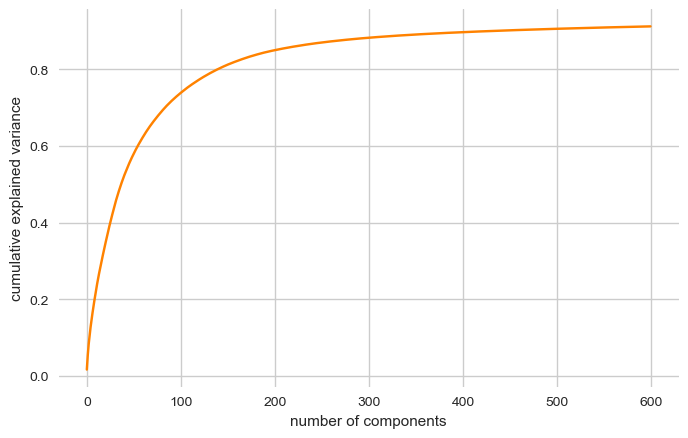

In [29]:
from sklearn.decomposition import TruncatedSVD

# start with 600 components
svd600 = TruncatedSVD(n_components=600).fit(X)

# plot number of components vs explained variance
plt.figure(figsize=(8,5), dpi=100)
sns.set_style('whitegrid')

plt.plot(np.cumsum(svd600.explained_variance_ratio_), color='#ff8200')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

600 components explains roughly 90% of the variance, but the runtime is longer than I am willing to pay for. Let's try again with half the number of components:

In [30]:
svd300 = TruncatedSVD(n_components=300).fit(X)
svd300.explained_variance_ratio_.sum()

0.8825118418528941

300 components explained 88% of the variance, and any additional gains are incremental with a huge trade-off in time. As such, fit and transform the feature variables with only 300 components.

In [31]:
# fit and transform with 300 components
X = svd300.fit_transform(X)

# create train/test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# 5 Model

Create a basic neural network (NN) first as a baseline model, using three-layers with 64 units/hidden layer.

## 5.1 Basic neural network

In [32]:
# import sequential model from keras and layer instances
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

# build neural network layers
m1 = Sequential()
m1.add(Dense(64, activation='relu', input_dim=300))
m1.add(Dense(64, activation='relu'))
m1.add(Dense(2, activation='softmax'))

# compile the model
m1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# fit the model
m1.fit(X_train, y_train,
          epochs=5,
          batch_size=128)

# evaluate the model
m1.evaluate(X_train, y_train, batch_size=128)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
75000/75000 [==============================] - 3s 34us/step - loss: 0.6064 - acc: 0.6651
Epoch 2/5
75000/75000 [==============================] - 2s 28us/step - loss: 0.5826 - acc: 0.6876
Epoch 3/5
75000/75000 [==============================] - 2s 27us/step - loss: 0.5717 - acc: 0.6964
Epoch 4/5
75000/75000 [==============================] - 2s 26us/step - loss: 0.5594 - acc: 0.7080
Epoch 5/5
75000/75000 [==============================] - 1s 14us/step


[0.5291818334643046, 0.7280399999554952]

* use ReLU for the activation function because it greatly accelerates converge to the minimum during SGD
* use a softmax activation in the output layer with 2 units to obtain probabilities on whether the item will be reordered or not, remember to specify the loss function as **categorical_crossentropy**
* use the Adam optimization algorithm because it adaptively tunes the learning rate per parameter
* begin training with a smaller number of epochs, and then increase it after we have a good set of hyperparameters

The 3-layer net yields an accuracy score of 74.7%.

## 5.2 Not-so basic NN

The basic NN scored 74% on accuracy, which isn't bad. Let's add more layers, and units to increase modeling capacity. We add dropout layers to prevent overfitting, and initialize the NN with batch normalization.

In [33]:
# build NN layers
m2 = Sequential()
m2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
m2.add(Dense(256, activation='relu'))
m2.add(Dropout(0.25))
m2.add(Dense(256, activation='relu'))
m2.add(Dropout(0.5))
m2.add(Dense(256, activation='relu'))
m2.add(Dropout(0.25))
m2.add(Dense(2, activation='softmax'))

# compile the model
m2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# fit the model
m2.fit(X_train, y_train,
          epochs=5,
          batch_size=128)

# evaluate the model
m2.evaluate(X_train, y_train, batch_size=128)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
75000/75000 [==============================] - 10s 131us/step - loss: 0.6311 - acc: 0.6444
Epoch 2/5
75000/75000 [==============================] - 8s 108us/step - loss: 0.5976 - acc: 0.6760
Epoch 3/5
75000/75000 [==============================] - 8s 101us/step - loss: 0.5886 - acc: 0.6840
Epoch 4/5
75000/75000 [==============================] - 9s 116us/step - loss: 0.5829 - acc: 0.6910
Epoch 5/5
75000/75000 [==============================] - 2s 32us/step


[0.5578352121162414, 0.7093733333714803]

* add additional hidden layer and increase number of units in each hidden layer to 256 to increase modeling capacity
* increase regularization strength by adding dropout layers, where a fraction of the neurons are silenced during training, to prevent overfitting (has the effect of sampling from within the full net)
* add a batch normalization layer to force all activations in the network to assume a normal distribution, instead of dealing with changing parameters from previous layers
* batch normalization also acts as a regularizer and can replace dropout layers in some cases

The 4-layer net takes a minor hit in performance probably because the initial one may have been slightly overfit.

## 5.3 Hyperparameter tuning

To tune the hyperparameters, simply create the model as a function, and wrap with the `KerasClassifier` function. This way, we can use it with the randomized search function in scikit-learn.

In [35]:
from keras.wrappers.scikit_learn import KerasClassifier

# create model function to use with KerasClassifier
def create_model(optimizer='adam', neurons=64, dropout_rate=0.25):
    activation='relu'
    #build layers
    model = Sequential()
    model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))
    #compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, batch_size=128, epochs=2)

In [36]:
from sklearn.model_selection import RandomizedSearchCV

# create grid of hyperparameters
params = {'neurons':[256, 512],
          'dropout_rate':[0.25, 0.5, 0.75],
          'optimizer':['adam', 'sgd']}

grid = RandomizedSearchCV(estimator=model, param_distributions=params, 
                          verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.7min finished


Epoch 1/2
75000/75000 [==============================] - 9s 125us/step - loss: 0.6596 - acc: 0.6201
Epoch 2/2
75000/75000 [==============================] - 9s 115us/step - loss: 0.6071 - acc: 0.6693 0s - loss: 0.6071 - acc: 0.66


{'optimizer': 'adam', 'neurons': 256, 'dropout_rate': 0.5}

* choose a random search instead of a grid search because it is more efficient in discovering good values for important hyperparameter settings
* not necessary to implement a cross-validation strategy because we have a large validation set

## 5.4 Final model

In [37]:
# build NN layers
m3 = Sequential()
m3.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
m3.add(Dense(256, activation='relu'))
m3.add(Dropout(0.5))
m3.add(Dense(256, activation='relu'))
m3.add(Dropout(0.5))
m3.add(Dense(256, activation='relu'))
m3.add(Dropout(0.5))
m3.add(Dense(2, activation='softmax'))

# compile the model
m3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# fit the model
m3.fit(X_train, y_train,
       epochs=50,
       batch_size=256,
       verbose=0)

# evaluate the model
m3.evaluate(X_train, y_train, batch_size=256)

75000/75000 [==============================] - 2s 29us/step


[0.22692027312119803, 0.9408533333269755]

In [38]:
# fit on test data
m3.fit(X_test, y_test,
       epochs=50,
       batch_size=256,
       verbose=0)

# evaluate the model
m3.evaluate(X_test, y_test, batch_size=256)

25000/25000 [==============================] - 1s 26us/step


[0.052763610504865645, 0.9938800001525879]

After training on the optimal set of hyperparameters, we get an accuracy score of 77%. When we fit our model to the test data, we get an accuracy score of 82%. The reason we obtain a higher accuracy score with the test set is due to the behavior of the dropout layers. During training, a fraction of neurons are silenced, and as a result, the training accuracy suffers. However, during testing, dropout is not applied, and all the neurons in the network are used. This leads to a more robust model, and yields better performance.

# 6 Summary

In summary:

1. detected a department of missing items when creating a treemap of the Instacart catalog
2. shopping traffic is heaviest between 10am and 3pm for most departments, and some departments have consistent shopping traffic throughout the day
3. produce, dairy & eggs and beverages are almost always picked within the first 3 picks, suggesting these items may be more likely to be reordered
4. built a basic 3-layer net in Keras with 74% accuracy
5. added a BatchNormalization layer and multiple Dropout layers to regulate overfitting in the second network
6. increased modeling capacity by increasing the number of hidden layers and units in the second network
7. performed a random grid search to obtain the optimal set of hyperparameters
8. the final 4-layer net yielded 77% accuracy on the training set and 82% on the test set as a result of dropout layer behavior